## Age of the oceans / depth of the oceans





In [1]:
## This is a worked example for stripy if we don't use litho1.0 information

import litho1pt0 as litho1pt0
import stripy
import numpy as np

import gdal
import cartopy
import cartopy.crs as ccrs


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
even_mesh = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, tree=True, refinement_levels=2)
number_of_mesh_points = even_mesh.npoints

In [4]:
latitudes_in_radians = even_mesh.lats
latitudes_in_degrees = np.degrees(latitudes_in_radians) 

longitudes_in_radians = even_mesh.lons 
longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

In [7]:
## Obtain bathymetry information from the ETOPO1 dataset and store in numpy image format

gtiff = gdal.Open("../../../Data/Resources/ETOPO1_Ice_c_geotiff.tif")
# width = gtiff.RasterXSize
# height = gtiff.RasterYSize
# gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T
img = np.fliplr(img)


In [8]:
## Obtain the age data and store in img format

datasize = (1801, 3601, 3)
age_data = np.empty(datasize)

ages = np.load("Data/global_age_data.3.6.z.npz")["ageData"]
ages[np.isnan(ages)] = -1000.0
ages = (np.fliplr(ages.T))


In [9]:
## Map heights to the sample grid points

def map_raster_to_mesh(mesh, raster):

    latitudes_in_radians  = mesh.lats
    longitudes_in_radians = mesh.lons 
    latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
    longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

    dlons = np.mod(longitudes_in_degrees+180.0, 360.0)
    dlats = np.mod(latitudes_in_degrees+90, 180.0)

    ilons = raster.shape[0] * dlons / 360.0
    ilats = raster.shape[1] * dlats / 180.0

    icoords = np.array((ilons, ilats))

    from scipy import ndimage

    mvals = ndimage.map_coordinates(raster, icoords , order=3, mode='nearest').astype(np.float)
    
    return mvals



In [10]:
meshheights = map_raster_to_mesh(even_mesh, img)
meshages    = map_raster_to_mesh(even_mesh, ages)

In [11]:
## Improve the grid to be dense in the oceans, sparse elsewhere, then remap the data

## Some code here

## If you refine the mesh to add new points / delete points on land etc, realise that you
## will need to re-map the data to the new mesh. You probably should make a function to do that for each 
## dataset.

for i in range(0,3):
    nodes_to_refine = np.where(meshheights < -1000)
    allnodes = even_mesh.centroid_refine_triangulation_by_vertices(nodes_to_refine)
    even_mesh = stripy.sTriangulation(allnodes[0], allnodes[1], tree=True)
    meshheights = map_raster_to_mesh(even_mesh, img)
    meshages    = map_raster_to_mesh(even_mesh, ages)
    
    latitudes_in_radians  = even_mesh.lats
    longitudes_in_radians = even_mesh.lons 
    latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
    longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0


In [12]:
## Smooth mesh heights

meshweights = (meshheights > 0.0) * 1.0 + 0.1

smeshheights, sdx = even_mesh.smoothing(meshheights, meshweights, 1.0, 0.25, 0.0001)

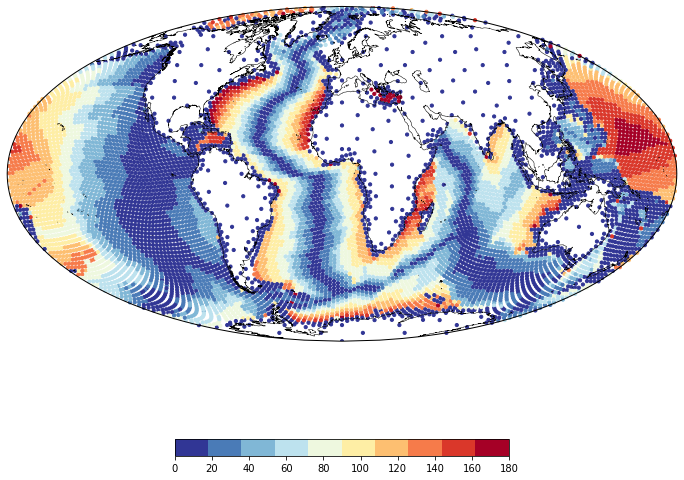

In [13]:
## Is that sensible ?

%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

global_extent     = [-180.0, 180.0, -89, 89]

projection0 = ccrs.PlateCarree()
projection1 = ccrs.Orthographic(central_longitude=140.0, central_latitude=0.0, globe=None)
projection2 = ccrs.Mollweide()
projection3 = ccrs.Robinson()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=projection2)
ax.set_global()

colormap = plt.cm.get_cmap('RdYlBu_r', 10)

m = ax.scatter(longitudes_in_degrees, latitudes_in_degrees, 
               c=meshages, cmap=colormap, vmin=0.0, vmax=180.0,
               s=10.0, transform=ccrs.Geodetic())

plt.colorbar(mappable=m, orientation="horizontal", shrink=0.5)
ax.coastlines(resolution="50m", zorder=100, linewidth=0.5)



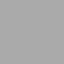

In [18]:
import lavavu

striangulationR = even_mesh

wireframeI = striangulationR
trianglesI = striangulationR

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[700,700], near=-10.0)

# Core 

cmapName = "diverge"

tris = lv.triangles("datagrid",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(striangulationR.points)
tris.indices(striangulationR.simplices)
tris.values(meshages, label="data")
tris.colourmap(cmapName, range=[0.0,200.0])

tris2 = lv.triangles("datagrid2",  wireframe=True, colour="#77ff88", opacity=1.0)
tris2.vertices(striangulationR.points*1.01)
tris2.indices(striangulationR.simplices)
tris2.values(meshages, label="data2")
tris2.colourmap(cmapName, range=[0.0,200.0])

tris.control.Checkbox(property='wireframe', label="Core - wireframe")

lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0)
lv.control.ObjectList()
lv.control.show()


(0.0, 200.0)

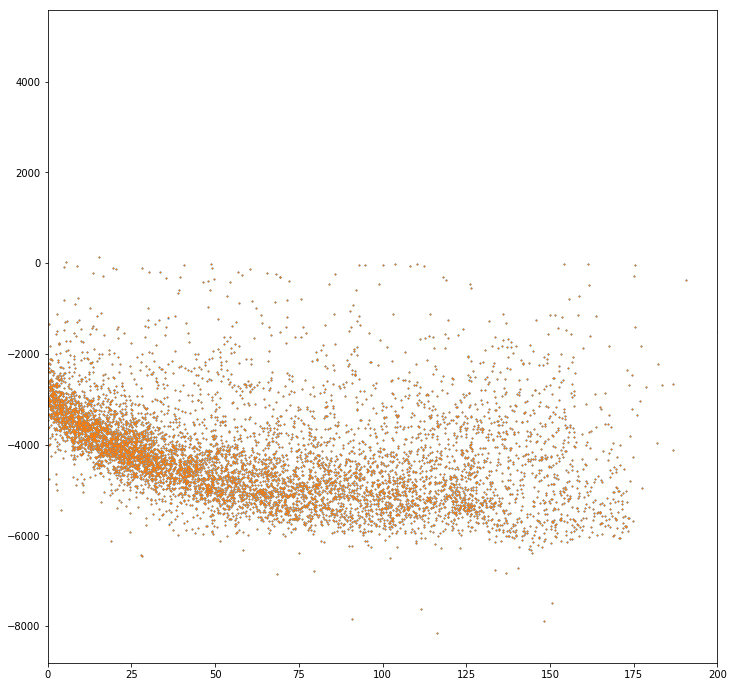

In [15]:
fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111)
ax.scatter(meshages, smeshheights,s=1.0)
ax.scatter(meshages, meshheights,s=0.5)
ax.set_xlim([0.0,200.0])

In [16]:
## Use scipy optimize to fit this data to  h = a + sqrt(b * age)

from scipy import optimize



In [17]:
smeshheights.max(), meshheights.max()

(4907.999, 4908.0)